In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.datasets import SpectrumDatasetOnOff, SpectrumDataset, Datasets
from gammapy.makers import SpectrumDatasetMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    SkyModel,
)
from gammapy.modeling.models import create_crab_spectral_model
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation, observatory_locations
from gammapy.maps import MapAxis, RegionGeom
#import ctaplot
#ctaplot.set_style('notebook')

from astropy import units as u
import matplotlib.pyplot as plt
from gammapy.modeling.models import (
    EBLAbsorptionNormSpectralModel,
    Models,
    PowerLawSpectralModel,
    SkyModel,
)

from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
    FluxPointsDataset,
)

from gammapy.estimators import FluxPointsEstimator
import scipy
import warnings
warnings.filterwarnings("ignore")

In [2]:
import ctaplot
ctaplot.set_style('slides')

In [10]:
#irf_path = './irf_20220303_v093_prod5_trans_80_zen20az180_dl1ab_tuned_psf_gamma_point-like_off04deg.fits.gz'
#irf_path = '/Users/joshuabaxter/Downloads/cta-prod5-zenodo-fitsonly-v0.1/fits/CTA-Performance-prod5-v0.1-North-LSTSubArray-20deg.FITS/Prod5-North-20deg-AverageAz-4LSTs.180000s-v0.1.fits.gz'

irf_path = './irf_zd_32.059deg_az_248.099deg_hardware_gh_dyn0.9_theta_dyn0.75.fits.gz'

In [11]:
def load_irf_dict_from_file_joshua(filename):
    import logging
    from astropy.io import fits
    from gammapy.data.hdu_index_table import HDUIndexTable
    from gammapy.utils.fits import HDULocation
    from gammapy.utils.scripts import make_path

    IRF_DL3_AXES_SPECIFICATION = {
        "THETA": {"name": "offset", "interp": "lin"},
        "ENERG": {"name": "energy_true", "interp": "log"},
        "ETRUE": {"name": "energy_true", "interp": "log"},
        "RAD": {"name": "rad", "interp": "lin"},
        "DETX": {"name": "fov_lon", "interp": "lin"},
        "DETY": {"name": "fov_lat", "interp": "lin"},
        "MIGRA": {"name": "migra", "interp": "lin"},
    }

    COMMON_HEADERS = {
        "HDUCLASS": "GADF",
        "HDUDOC": "https://github.com/open-gamma-ray-astro/gamma-astro-data-formats",
        "HDUVERS": "0.2",
    }

    COMMON_IRF_HEADERS = {
        **COMMON_HEADERS,
        "HDUCLAS1": "RESPONSE",
    }


    # The key is the class tag.
    # TODO: extend the info here with the minimal header info
    IRF_DL3_HDU_SPECIFICATION = {
        "bkg_3d": {
            "extname": "BACKGROUND",
            "column_name": "BKG",
            "mandatory_keywords": {
                **COMMON_IRF_HEADERS,
                "HDUCLAS2": "BKG",
                "HDUCLAS3": "FULL-ENCLOSURE",  # added here to have HDUCLASN in order
                "HDUCLAS4": "BKG_3D",
            },
        },
        "bkg_2d": {
            "extname": "BACKGROUND",
            "column_name": "BKG",
            "mandatory_keywords": {
                **COMMON_IRF_HEADERS,
                "HDUCLAS2": "BKG",
                "HDUCLAS3": "FULL-ENCLOSURE",  # added here to have HDUCLASN in order
                "HDUCLAS4": "BKG_2D",
            },
        },
        "edisp_2d": {
            "extname": "ENERGY DISPERSION",
            "column_name": "MATRIX",
            "mandatory_keywords": {
                **COMMON_IRF_HEADERS,
                "HDUCLAS2": "EDISP",
                "HDUCLAS3": "FULL-ENCLOSURE",  # added here to have HDUCLASN in order
                "HDUCLAS4": "EDISP_2D",
            },
        },
        "psf_table": {
            "extname": "PSF_2D_TABLE",
            "column_name": "RPSF",
            "mandatory_keywords": {
                **COMMON_IRF_HEADERS,
                "HDUCLAS2": "RPSF",
                "HDUCLAS3": "FULL-ENCLOSURE",  # added here to have HDUCLASN in order
                "HDUCLAS4": "PSF_TABLE",
            },
        },
        "psf_3gauss": {
            "extname": "PSF_2D_GAUSS",
            "column_name": {
                "sigma_1": "SIGMA_1",
                "sigma_2": "SIGMA_2",
                "sigma_3": "SIGMA_3",
                "scale": "SCALE",
                "ampl_2": "AMPL_2",
                "ampl_3": "AMPL_3",
            },
            "mandatory_keywords": {
                **COMMON_IRF_HEADERS,
                "HDUCLAS2": "RPSF",
                "HDUCLAS3": "FULL-ENCLOSURE",  # added here to have HDUCLASN in order
                "HDUCLAS4": "PSF_3GAUSS",
            },
        },
        "psf_king": {
            "extname": "PSF_2D_KING",
            "column_name": {
                "sigma": "SIGMA",
                "gamma": "GAMMA",
            },
            "mandatory_keywords": {
                **COMMON_IRF_HEADERS,
                "HDUCLAS2": "RPSF",
                "HDUCLAS3": "FULL-ENCLOSURE",  # added here to have HDUCLASN in order
                "HDUCLAS4": "PSF_KING",
            },
        },
        "aeff_2d": {
            "extname": "EFFECTIVE AREA",
            "column_name": "EFFAREA",
            "mandatory_keywords": {
                **COMMON_IRF_HEADERS,
                "HDUCLAS2": "EFF_AREA",
                "HDUCLAS3": "FULL-ENCLOSURE",  # added here to have HDUCLASN in order
                "HDUCLAS4": "AEFF_2D",
            },
        },
        "rad_max_2d": {
            "extname": "RAD_MAX",
            "column_name": "RAD_MAX",
            "mandatory_keywords": {
                **COMMON_IRF_HEADERS,
                "HDUCLAS2": "RAD_MAX",
                "HDUCLAS3": "POINT-LIKE",
                "HDUCLAS4": "RAD_MAX_2D",
            },
        },
    }


    IRF_MAP_HDU_SPECIFICATION = {
        "edisp_kernel_map": "edisp",
        "edisp_map": "edisp",
        "psf_map": "psf",
    }

    """Open a fits file and generate a dictionary containing the Gammapy objects
    corresponding to the IRF components stored

    Parameters
    ----------
    filename : str, Path
        path to the file containing the IRF components, if EVENTS and GTI HDUs
        are included in the file, they are ignored

    Returns
    -------
    irf_dict : dict of `~gammapy.irf.IRF`
        dictionary with instances of the Gammapy objects corresponding
        to the IRF components
    """
    from gammapy.irf.rad_max import RadMax2D

    filename = make_path(filename)

    hdulist = fits.open(make_path(filename))

    irf_dict = {}

    is_pointlike = False

    for hdu in hdulist:
        hdu_class = hdu.header.get("HDUCLAS1", "").lower()

        if hdu_class == "response":
            hdu_class = hdu.header.get("HDUCLAS4", "").lower()

            is_pointlike |= hdu.header["HDUCLAS3"] == "POINT-LIKE"

            loc = HDULocation(
                hdu_class=hdu_class,
                hdu_name=hdu.name,
                file_dir=filename.parent,
                file_name=filename.name,
            )

            for name in HDUIndexTable.VALID_HDU_TYPE:
                if name in hdu_class:
                    print(name)
                    if name in irf_dict.keys():
                        #log.warning(f"more than one HDU of {name} type found")
                        #log.warning(
                        #    f"loaded the {irf_dict[name].meta['EXTNAME']} HDU in the dictionary"
                        #)
                        continue
                    data = loc.load()
                    # TODO: maybe introduce IRF.type attribute...
                    if 'bkg' in name:
                        irf_dict[name] = data
                        foo = irf_dict[name].to_3d()
                        irf_dict.pop(name)
                        irf_dict[name] = foo
                    else:
                        irf_dict[name] = data
                    #irf_dict[name] = data
        else:  # not an IRF component
            continue

    if is_pointlike and "rad_max" not in irf_dict:
        irf_dict["rad_max"] = RadMax2D.from_irf(irf_dict["aeff"])

    return irf_dict

In [12]:
irfs =  load_irf_dict_from_file_joshua(irf_path)

rad_max
aeff
edisp
bkg


In [13]:
source_name = "Mrk501"
obs_time = 50

In [14]:
# Define simulation parameters
livetime = obs_time* u.h

pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.4 * u.deg

# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-2.0, 1.0, 20), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-3.0, 2.0, 41), unit="TeV", name="energy_true", interp="log"
)

on_region_radius = Angle("0.10 deg")

center = pointing.directional_offset_by(
    position_angle=0 * u.deg, separation=offset
)
on_region = CircleSkyRegion(center=center, radius=on_region_radius)

In [15]:
model_sim = PowerLawSpectralModel(index=2.19, amplitude=8.27e-12 * u.Unit("cm-2 s-1 TeV-1"),reference=1.42 * u.TeV)
#PowerLawSpectralModel(index=1.74, amplitude=8.98e-11 * u.Unit("cm-2 s-1 TeV-1"),reference=2.17 * u.TeV) 
PowerLawSpectralModel(index=2.19, amplitude=8.27e-12 * u.Unit("cm-2 s-1 TeV-1"),reference=1.42 * u.TeV)
#PowerLawSpectralModel(index=1.74, amplitude=8.98e-11 * u.Unit("cm-2 s-1 TeV-1"),reference=2.17 * u.TeV) ##mrk421
#PowerLawSpectralModel(index=2.19, amplitude=8.27e-12 * u.Unit("cm-2 s-1 TeV-1"),reference=1.42 * u.TeV)

absorption = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=0.034, alpha_norm = 1.0)
#absorption.alpha_norm.min = 0.3
absorption.alpha_norm.frozen = True
model_of_absorp =model_sim*absorption

# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_of_absorp, name="source")
print(model)

location = observatory_locations["cta_south"]
obs = Observation.create(
    pointing=pointing,
    livetime=livetime,
    irfs=irfs,
    location=location,
)

# Make the SpectrumDataset
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="obs-0"
)
maker = SpectrumDatasetMaker(selection=["exposure", "edisp", "background"])

dataset = maker.run(dataset_empty, obs)

# Set the model on the dataset, and fake
dataset.models = model
dataset.fake(random_state=42)
#print(dataset)

dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, acceptance=1, acceptance_off=3
)
dataset_on_off.fake(npred_background=dataset.npred_background())
#print(dataset_on_off)

n_obs =100
datasets = Datasets()

for idx in range(n_obs):
    dataset_on_off.fake(
        random_state=idx, npred_background=dataset.npred_background()
    )
    print(dataset_on_off)
    dataset_fake = dataset_on_off.copy(name=f"obs-{idx}")
    dataset_fake.meta_table["OBS_ID"] = [idx]
    datasets.append(dataset_fake)

table = datasets.info_table()

SkyModel

  Name                      : source
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.190   +/-    0.00             
    amplitude                     :   8.27e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.420       TeV         
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.034                   


SpectrumDatasetOnOff
--------------------

  Name                            : 9bXbW5J8 

  Total counts                    : 88620 
  Total background counts         : 32220.00
  Total excess counts             : 56400.00

  Predicted counts                : 88368.23
  Predicted background counts     : 32239.16
  Predicted excess counts         : 56129.07

  Exposure min                    : 3.48e+06 m2 s
  Exposure max               

SpectrumDatasetOnOff
--------------------

  Name                            : 9bXbW5J8 

  Total counts                    : 88388 
  Total background counts         : 32195.67
  Total excess counts             : 56192.33

  Predicted counts                : 88298.33
  Predicted background counts     : 32169.26
  Predicted excess counts         : 56129.07

  Exposure min                    : 3.48e+06 m2 s
  Exposure max                    : 4.01e+10 m2 s

  Number of total bins            : 19 
  Number of fit bins              : 19 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 26.31

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index       

SpectrumDatasetOnOff
--------------------

  Name                            : 9bXbW5J8 

  Total counts                    : 88387 
  Total background counts         : 32071.33
  Total excess counts             : 56315.67

  Predicted counts                : 88226.49
  Predicted background counts     : 32097.42
  Predicted excess counts         : 56129.07

  Exposure min                    : 3.48e+06 m2 s
  Exposure max                    : 4.01e+10 m2 s

  Number of total bins            : 19 
  Number of fit bins              : 19 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 19.90

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index       

SpectrumDatasetOnOff
--------------------

  Name                            : 9bXbW5J8 

  Total counts                    : 88436 
  Total background counts         : 32208.00
  Total excess counts             : 56228.00

  Predicted counts                : 88354.83
  Predicted background counts     : 32225.76
  Predicted excess counts         : 56129.07

  Exposure min                    : 3.48e+06 m2 s
  Exposure max                    : 4.01e+10 m2 s

  Number of total bins            : 19 
  Number of fit bins              : 19 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 13.51

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index       

SpectrumDatasetOnOff
--------------------

  Name                            : 9bXbW5J8 

  Total counts                    : 88856 
  Total background counts         : 32084.00
  Total excess counts             : 56772.00

  Predicted counts                : 88286.82
  Predicted background counts     : 32157.75
  Predicted excess counts         : 56129.07

  Exposure min                    : 3.48e+06 m2 s
  Exposure max                    : 4.01e+10 m2 s

  Number of total bins            : 19 
  Number of fit bins              : 19 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16.73

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index       

SpectrumDatasetOnOff
--------------------

  Name                            : 9bXbW5J8 

  Total counts                    : 88933 
  Total background counts         : 32189.33
  Total excess counts             : 56743.67

  Predicted counts                : 88378.79
  Predicted background counts     : 32249.72
  Predicted excess counts         : 56129.07

  Exposure min                    : 3.48e+06 m2 s
  Exposure max                    : 4.01e+10 m2 s

  Number of total bins            : 19 
  Number of fit bins              : 19 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 21.75

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index       

SpectrumDatasetOnOff
--------------------

  Name                            : 9bXbW5J8 

  Total counts                    : 88360 
  Total background counts         : 32217.33
  Total excess counts             : 56142.67

  Predicted counts                : 88354.03
  Predicted background counts     : 32224.96
  Predicted excess counts         : 56129.07

  Exposure min                    : 3.48e+06 m2 s
  Exposure max                    : 4.01e+10 m2 s

  Number of total bins            : 19 
  Number of fit bins              : 19 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 12.02

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index       

SpectrumDatasetOnOff
--------------------

  Name                            : 9bXbW5J8 

  Total counts                    : 88361 
  Total background counts         : 32086.33
  Total excess counts             : 56274.67

  Predicted counts                : 88253.57
  Predicted background counts     : 32124.50
  Predicted excess counts         : 56129.07

  Exposure min                    : 3.48e+06 m2 s
  Exposure max                    : 4.01e+10 m2 s

  Number of total bins            : 19 
  Number of fit bins              : 19 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 24.79

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index       

SpectrumDatasetOnOff
--------------------

  Name                            : 9bXbW5J8 

  Total counts                    : 88571 
  Total background counts         : 32221.00
  Total excess counts             : 56350.00

  Predicted counts                : 88373.71
  Predicted background counts     : 32244.64
  Predicted excess counts         : 56129.07

  Exposure min                    : 3.48e+06 m2 s
  Exposure max                    : 4.01e+10 m2 s

  Number of total bins            : 19 
  Number of fit bins              : 19 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 11.13

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index       

SpectrumDatasetOnOff
--------------------

  Name                            : 9bXbW5J8 

  Total counts                    : 88587 
  Total background counts         : 32170.33
  Total excess counts             : 56416.67

  Predicted counts                : 88309.05
  Predicted background counts     : 32179.98
  Predicted excess counts         : 56129.07

  Exposure min                    : 3.48e+06 m2 s
  Exposure max                    : 4.01e+10 m2 s

  Number of total bins            : 19 
  Number of fit bins              : 19 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 18.47

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index       

SpectrumDatasetOnOff
--------------------

  Name                            : 9bXbW5J8 

  Total counts                    : 88363 
  Total background counts         : 32203.33
  Total excess counts             : 56159.67

  Predicted counts                : 88319.51
  Predicted background counts     : 32190.44
  Predicted excess counts         : 56129.07

  Exposure min                    : 3.48e+06 m2 s
  Exposure max                    : 4.01e+10 m2 s

  Number of total bins            : 19 
  Number of fit bins              : 19 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 8.43

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index        

SpectrumDatasetOnOff
--------------------

  Name                            : 9bXbW5J8 

  Total counts                    : 88425 
  Total background counts         : 32259.33
  Total excess counts             : 56165.67

  Predicted counts                : 88388.93
  Predicted background counts     : 32259.86
  Predicted excess counts         : 56129.07

  Exposure min                    : 3.48e+06 m2 s
  Exposure max                    : 4.01e+10 m2 s

  Number of total bins            : 19 
  Number of fit bins              : 19 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 16.98

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index       

In [16]:
def get_model_for_fit(alpha_norm):
    model_fit_bf_ab = PowerLawSpectralModel(index=2, amplitude=5e-12 * u.Unit("cm-2 s-1 TeV-1"),reference=1.42 * u.TeV)
    ab =  EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=0.034, alpha_norm = alpha_norm)
    #ab.parameters['alpha_norm'].frozen = False
    model_fit_af_ab = model_fit_bf_ab*ab
    model_for_fit = SkyModel(spectral_model=model_fit_af_ab, name="fit")
    return model_for_fit

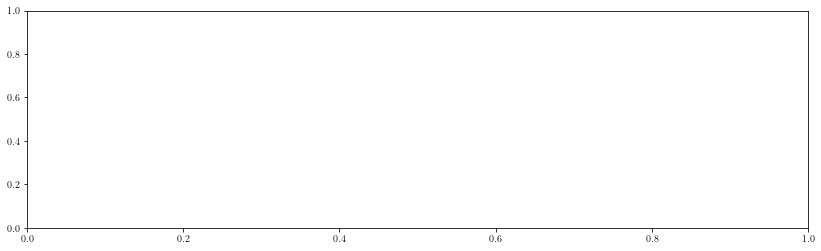

In [17]:
fit_results = {}
fit = Fit()
minuit_opts = {"tol": 0.01, "strategy": 1}
fit.backend = "minuit"
fit.optimize_opts = minuit_opts
alpha_norm_selection =np.linspace(0.3,2.5,23).tolist()
results = []
min_chi_square_dic = {}
total_stat_box = np.zeros(shape = (len(datasets),len(alpha_norm_selection)))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 4))

for i, data in enumerate(datasets):
    min_chi_square = []
    for j,alpha in enumerate(alpha_norm_selection):
        model_fit = get_model_for_fit(alpha_norm=alpha)
        model_fit.parameters['alpha_norm'].frozen = True
        data.models = model_fit.copy()
        fiter = Fit()
        result = fiter.run(data)
        total_stat = result.total_stat
        total_stat_box[i][j] = total_stat
    total_stat_box[i] = total_stat_box[i] - total_stat_box[i].min()
        #par1 = dataset.models.parameters.free_parameters[0]
        #par2 = dataset.models.parameters.free_parameters[1]

        #fit_results[alpha] = fiter.stat_surface(datasets = dataset, x = par1, y = par2, reoptimize=False)
        #min_chi_square.append(fit_results[alpha]['stat_scan'].min())
        #print(min_chi_square)
    #min_chi_square_dic[f'{i}'] = min_chi_square
    #ax.plot(alpha_norm_selection, np.array(min_chi_square)/17)
    
    #ax.set_xlabel(f"{par.name} [{par.unit}]")
    #ax.set_ylabel(r"$\Delta$ TS")
    #ax.set_ylim(-0.4,10)
    #ax.set_xlim(0.5,1.7)
   

In [18]:
def get_y_towards_value(stat_box,fake_time,idx):
    foo = []
    for i in range(fake_time - 1):
        j = idx
        foo.append(total_stat_box[i][j-1:j][0])
    return np.array(foo)

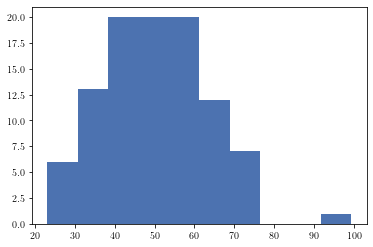

In [19]:
y_mean_alpha_chisq, y_err_alpha_chisq = [],[]
for i in range(23):
    foo = get_y_towards_value(total_stat_box, len(datasets),i+1)
    y_mean_alpha_chisq.append(foo.mean())
    y_err_alpha_chisq.append(foo.std())
    if i==0: plt.hist(foo)

In [20]:
np_path_mean = f"./numpy_store/longtime_monitor_ver3/ebl_scaling/{source_name}_{obs_time}_mean_hst.npy"
np_path_err = f"./numpy_store/longtime_monitor_ver3/ebl_scaling/{source_name}_{obs_time}_err_hst.npy"
np.save(np_path_mean,y_mean_alpha_chisq)
np.save(np_path_err,y_err_alpha_chisq)

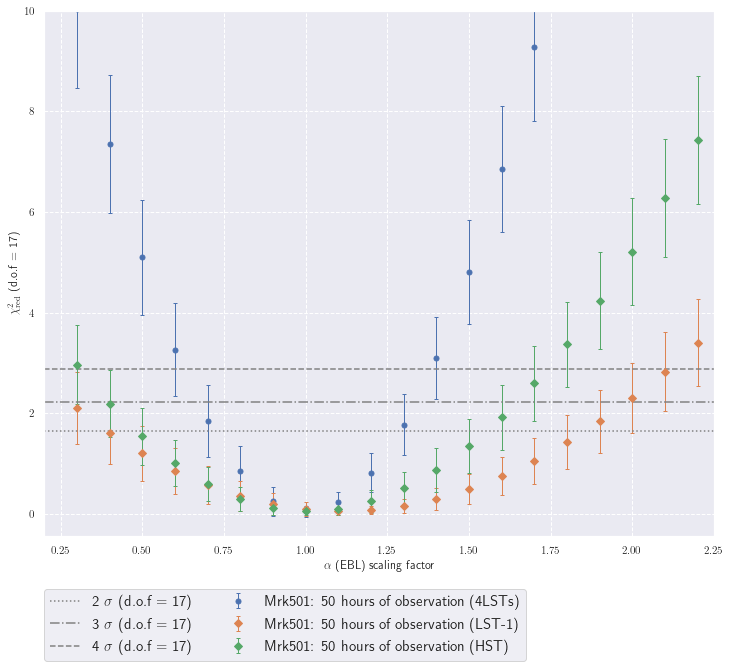

In [28]:
plt.figure(figsize=(12,10)) 
plot_kwargs = {
"capsize":2,
"fmt": "o",
"markersize": 5,
"linewidth":1,
}
np_path_base = "./numpy_store/longtime_monitor_ver3/ebl_scaling/"

#np_path_base = "./numpy_store/longtime_monitor_ver3/ebl_scaling/"
for i,obs_time in enumerate([50]):
    y_mean_alpha_chisq = np.load(np_path_base+f"{source_name}_{obs_time}_mean_lst4.npy")
    y_err_alpha_chisq = np.load(np_path_base+f"{source_name}_{obs_time}_err_lst4.npy")
    
    plt.errorbar(x = alpha_norm_selection, y =np.array(y_mean_alpha_chisq)/17,yerr = np.array(y_err_alpha_chisq)/17
                 ,**plot_kwargs,
                label = f"{source_name}: {obs_time} hours of observation (4LSTs)")
    
    y_mean_alpha_chisq = np.load(np_path_base+f"{source_name}_{obs_time}_mean.npy")
    y_err_alpha_chisq = np.load(np_path_base+f"{source_name}_{obs_time}_err.npy")
    
    plt.errorbar(x = alpha_norm_selection, y =np.array(y_mean_alpha_chisq)/17,yerr = np.array(y_err_alpha_chisq)/17
             ,**plot_kwargs,
            label = f"{source_name}: {obs_time} hours of observation (LST-1)",marker = "D")
    
    y_mean_alpha_chisq = np.load(np_path_base+f"{source_name}_{obs_time}_mean_hst.npy")
    y_err_alpha_chisq = np.load(np_path_base+f"{source_name}_{obs_time}_err_hst.npy")

    plt.errorbar(x = alpha_norm_selection, y =np.array(y_mean_alpha_chisq)/17,yerr = np.array(y_err_alpha_chisq)/17
         ,**plot_kwargs,
        label = f"{source_name}: {obs_time} hours of observation (HST)",marker = "D")
    
    

# plt.errorbar(x = alpha_norm_selection, y =np.array(y_mean_alpha_chisq)/17,yerr = np.array(y_err_alpha_chisq)/17,**plot_kwargs,
#             label = f"{source_name}: {obs_time} hours of observation")
sigma = r'$\sigma$'
#plt.axhline(y = get_minimal_chi2(1,17)/17,label = f"1 {sigma} (d.o.f = 17)", linestyle="dashed",color = "grey")
plt.axhline(y = get_minimal_chi2(2,17)/17,label = f"2 {sigma} (d.o.f = 17)",linestyle="dotted",color = "grey")
plt.axhline(y = get_minimal_chi2(3,17)/17,label = f"3 {sigma} (d.o.f = 17)",linestyle="dashdot",color = "grey")
plt.axhline(y = get_minimal_chi2(4,17)/17,label = f"4 {sigma} (d.o.f = 17)",linestyle="dashed",color = "grey")
#plt.grid(color = "gray", linestyle="--")
plt.xlim(0.20,2.25)
plt.ylim(-0.45,10)
plt.xlabel(r'$\alpha$ (EBL) scaling factor')
plt.ylabel(r'$\chi_{\mathrm{red}}^2$ (d.o.f = 17)')
plt.legend(bbox_to_anchor=(-0.0, -0.1), loc='upper left', borderaxespad=0, ncol=2,fontsize = 15)
plt.savefig(f"./ebl_scaling_{source_name}_lst4andlst_hst.pdf", bbox_inches='tight')
#ax.legend(loc='upper center', bbox_to_anchor=(-0.1, -0.35), ncol=2)

In [22]:
def get_minimal_chi2(cl, dof):
    # Note:
    # 1-2*scipy.stats.norm.sf(x) = 0.683,0.954,0.997 for x=1,2,3
    # scipy.stats.norm.isf(q=scipy.stats.norm.sf(x=3)) = 3
    # scipy.stats.chi2.isf(q=scipy.stats.chi2.sf(x=4, df=2), df=2) = 4
    return scipy.stats.chi2.isf(q=2*scipy.stats.norm.sf(x=cl), df=dof)

In [23]:
import seaborn as sns

In [24]:
sns.set()
sns.set_style("darkgrid", {'grid.linestyle': '--'})

In [25]:
plt.rcParams['figure.subplot.bottom'] = 0.15